 Theunderlying SC was constructed by (i) drawing 400 random points in the unit square;(ii) generating a triangular lattice via Delauney triangulation; (iii) eliminating edgesinside two predefined regions; and (iv) defining all triangles to be faces.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import networkx as nx
import scipy as sc
from scipy.spatial import Delaunay
from scipy.spatial.distance import cdist
import random

import pickle

from simplicial_kuramoto import SimplicialComplex
from simplicial_kuramoto.graph_generator import modular_graph
from simplicial_kuramoto.integrators import *
from simplicial_kuramoto import plotting

In [88]:
def get_delauney_holes_multi(n_points, centre_holes,   radius,points=[]):


    if(len(points)==0):
        x = np.random.rand(n_points)
        y = np.random.rand(n_points)
        points = np.vstack([x,y]).T

    tri = Delaunay(points)

    edge_list = []
    
    
    idx_inside=np.empty([0], dtype=int)
    for i in range(centre_holes.shape[0]):
        idx_inside=np.hstack([idx_inside,encloses([centre_holes[i]],points,radius)[1]])
    
    for t in tri.simplices:
        
        if t[0] not in idx_inside and t[1] not in idx_inside:
            edge_list.append([t[0], t[1]])
     
        if t[1] not in idx_inside and t[2] not in idx_inside:
            edge_list.append([t[1], t[2]])

        if t[0] not in idx_inside and t[2] not in idx_inside:
            edge_list.append([t[0], t[2]])   


            
    graph = nx.Graph()
    #graph.add_nodes_from(np.arange(len(points)))    
    graph.add_edges_from(edge_list)
    
    Gcc = sorted(nx.connected_components(graph), key=len, reverse=True)
    g = graph.subgraph(Gcc[0])
    
    
    return g, points


def encloses(centre, points, radius):
    inside_hole = (cdist(centre, points, 'euclidean') <= radius)
    idx_inside = np.where(inside_hole )
    
    return idx_inside




# Test for mulitple holes and nullspace plotting

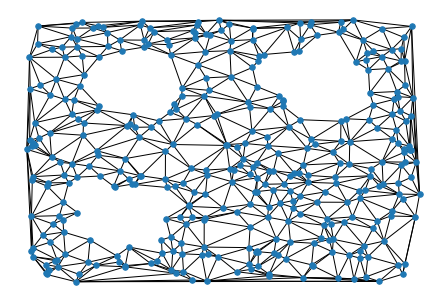

In [102]:
centre_hole_1 = np.array([[0.25,0.25]])
centre_hole_2 = np.array([[0.75,0.75]])
centre_hole_3 = np.array([[0.25,0.75]])

centre_holes=np.concatenate((centre_hole_1,centre_hole_2,centre_hole_3),axis=0)

radius = 0.1

graph, points = get_delauney_holes_multi(400,centre_holes, radius)
pos = dict(enumerate(points))
nx.draw(graph,pos,node_size=30)


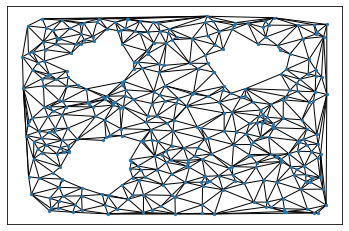

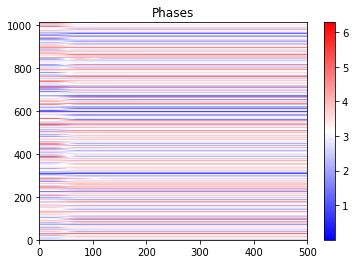

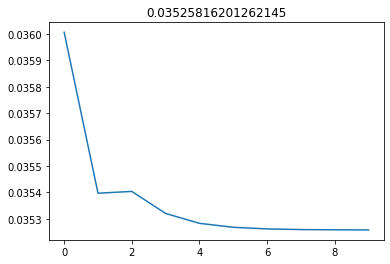

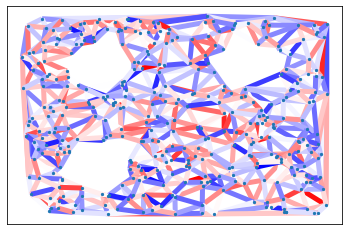

In [70]:
plt.figure()
nx.draw_networkx_nodes(graph, pos=points, node_size=5)
nx.draw_networkx_edges(graph, pos=points)

labels = dict(((u, v), d) for d, (u, v) in enumerate(graph.edges))


np.random.seed(0)
initial_phase = np.random.uniform(0, 2 * np.pi, len(graph.edges))


t_max = 500
n_t = 10

complex_delaunay = SimplicialComplex(graph=graph, no_faces=False)

edge_result = integrate_edge_kuramoto(complex_delaunay, initial_phase, t_max, n_t)
plotting.plot_edge_kuramoto(edge_result)
    # plt.savefig("phases_no_faces.png")

plotting.plot_order_parameter(edge_result.y, return_op=False, plot=True)
    
plt.figure()
nx.draw_networkx_nodes(graph, pos=points, node_size=5)
nx.draw_networkx_edges(
        graph,
        pos=points,
        edge_color=edge_result.y[:, -1],
        edge_cmap=plt.get_cmap("bwr"),
        width=5,
        edge_vmin=np.min(edge_result.y),
        edge_vmax=np.max(edge_result.y),
    )

In [105]:
# Plotting the nullspace of L1

def Null_Space_Plot(graph):
    complex_delaunay = SimplicialComplex(graph=graph, no_faces=False)

    B0 = complex_delaunay.node_incidence_matrix
    W0 = complex_delaunay.node_weights_matrix
    B1 = complex_delaunay.edge_incidence_matrix
    W1 = complex_delaunay.edge_weights_matrix
    W2 = complex_delaunay.face_weights_matrix

    Ld = W1.dot(B0.dot(W0.dot(B0.T)))
    Lu = W1.dot(B1.T.dot(W2.dot(B1)))

    L1 = Ld + Lu

    KerL1=sc.linalg.null_space(L1.todense())

    for i in range(KerL1.shape[1]):
        plt.figure()
        nx.draw_networkx_nodes(graph, pos=points, node_size=5)
        nx.draw_networkx_edges(
                graph,
                pos=points,
                edge_color=KerL1[:,i],
                edge_cmap=plt.get_cmap("bwr"),
                width=5,
                edge_vmin=np.min(KerL1[:,i]),
                edge_vmax=np.max(KerL1[:,i]),
            )
        plt.title('Null space of L1, vector '+str(i))
        plt.show()

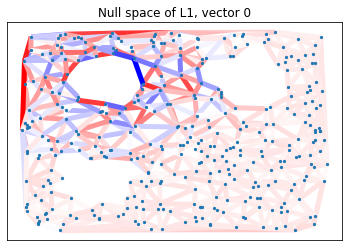

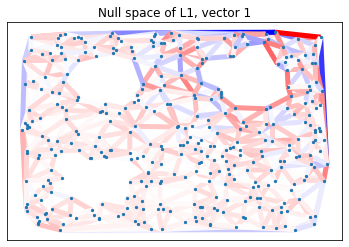

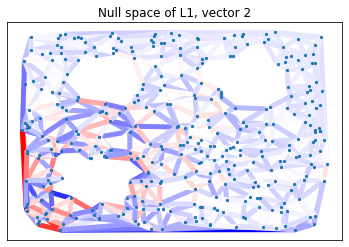

In [106]:
Null_Space_Plot(graph)

# Single hole size effect

Radius: 0.05


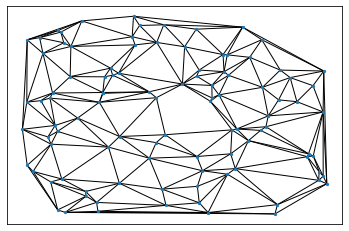

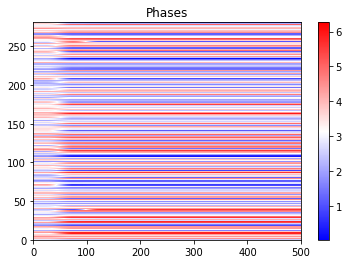

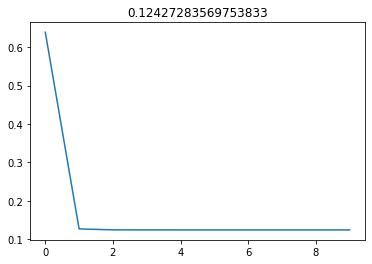

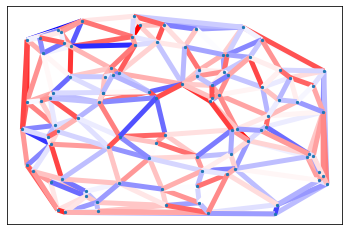

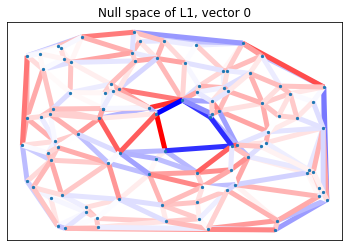

Radius: 0.1


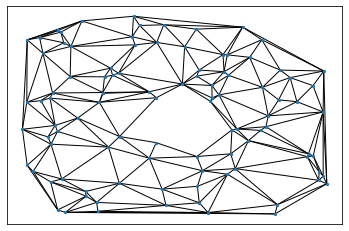

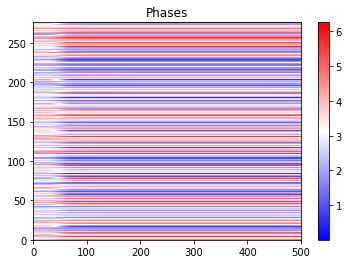

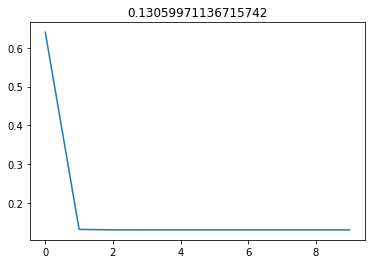

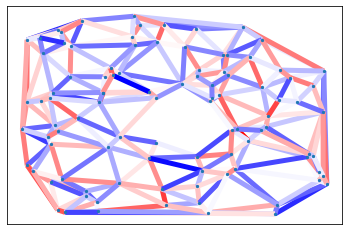

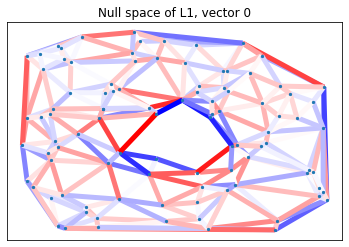

Radius: 0.2


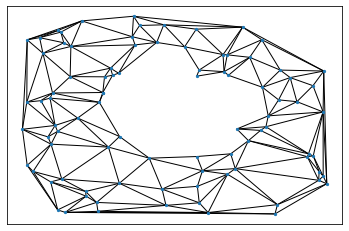

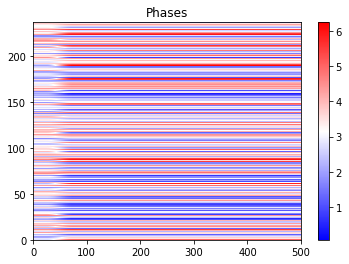

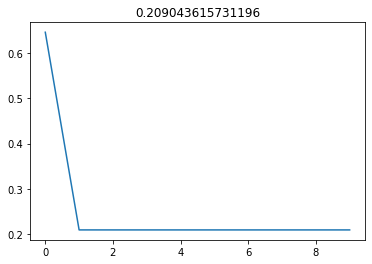

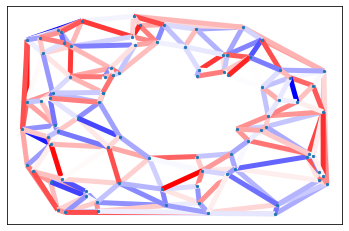

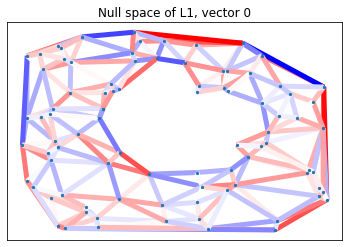

Radius: 0.3


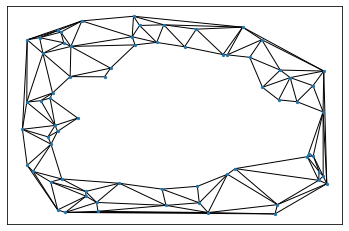

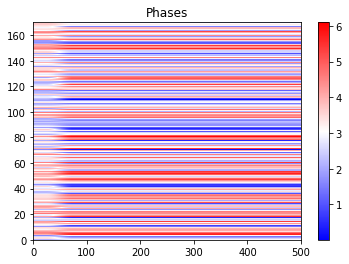

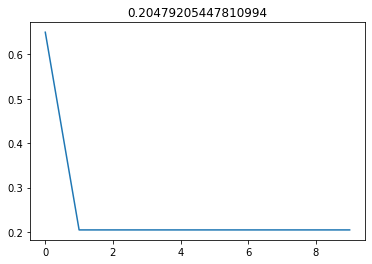

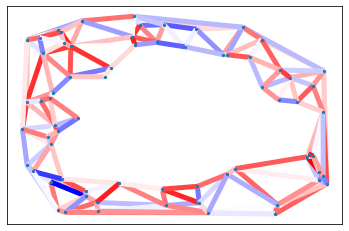

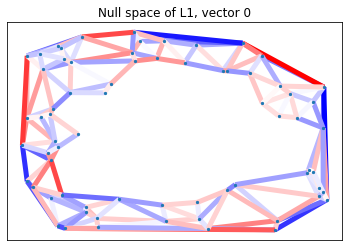

In [ ]:
centre_hole = np.array([[0.5,0.5]])

n_points=100
x = np.random.rand(n_points)
y = np.random.rand(n_points)
points = np.vstack([x,y]).T

radii=[0.05,0.1,0.2,0.3,0.4,0.5]

for radius in radii:
    print('Radius: '+str(radius))
    graph, points = get_delauney_holes_multi(n_points,centre_hole, radius,points)
    pos = dict(enumerate(points))
#     nx.draw(graph,pos,node_size=30)

    plt.figure()
    nx.draw_networkx_nodes(graph, pos=points, node_size=5)
    nx.draw_networkx_edges(graph, pos=points)

    labels = dict(((u, v), d) for d, (u, v) in enumerate(graph.edges))

    np.random.seed(0)
    initial_phase = np.random.uniform(np.pi/2, 3 * np.pi/2, len(graph.edges))

    t_max = 500
    n_t = 10

    complex_delaunay = SimplicialComplex(graph=graph, no_faces=False)

    edge_result = integrate_edge_kuramoto(complex_delaunay, initial_phase, t_max, n_t)
    plotting.plot_edge_kuramoto(edge_result)
        # plt.savefig("phases_no_faces.png")

    plotting.plot_order_parameter(edge_result.y, return_op=False, plot=True)

    plt.figure()
    nx.draw_networkx_nodes(graph, pos=points, node_size=5)
    nx.draw_networkx_edges(
            graph,
            pos=points,
            edge_color=edge_result.y[:, -1],
            edge_cmap=plt.get_cmap("bwr"),
            width=5,
            edge_vmin=np.min(edge_result.y),
            edge_vmax=np.max(edge_result.y),
        )
    Null_Space_Plot(graph)